# Импорт данных и зависимостей

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow.keras as keras
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' # для более четкой отрисовки графиков

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
ds = pd.read_csv('credit_data.csv', header=None) # загружаем данные
ds.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


# Анализ данных и препроцессинг

In [3]:
ds.columns = ['a_'+str(i) for i in range(ds.shape[1]-1)] + ['target'] # пронумеруем признаки и обозначим целевой признак
ds['target'] = ds['target'].map({'+':1, '-':0}) # приведем целевую переменную к численному виду

In [4]:
ds # посмотри на датасет

,a_0,a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,a_12,a_13,a_14,target
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,b,21.08,10.085,y,p,e,h,1.25,f,f,0,f,g,00260,0,0
686,a,22.67,0.750,u,g,c,v,2.00,f,t,2,t,g,00200,394,0
687,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1,t,g,00200,1,0
688,b,17.92,0.205,u,g,aa,v,0.04,f,f,0,f,g,00280,750,0


Проведем краткий стандартный анализ датасета и подготовим его для применения алгоритмой машинного обучения:

In [5]:
ds.dtypes

a_0        object
a_1        object
a_2       float64
a_3        object
a_4        object
a_5        object
a_6        object
a_7       float64
a_8        object
a_9        object
a_10        int64
a_11       object
a_12       object
a_13       object
a_14        int64
target      int64
dtype: object

Кажется, что признаки 'a_1' и 'a_13' должны быть также числовыми - приведем их к этому виду:

In [6]:
ds['a_1'] = pd.to_numeric(ds['a_1'], errors='coerce')
ds['a_13'] = pd.to_numeric(ds['a_13'], errors='coerce')

In [7]:
num_cols = ds.drop('target', axis=1).select_dtypes(exclude='O').columns

In [8]:
ds['target'].value_counts() # --> датасет сбаллансированный

0    383
1    307
Name: target, dtype: int64

In [9]:
ds = pd.get_dummies(ds) # закодируем категориальные признаки

In [10]:
ds['a_1'].fillna(ds['a_1'].median(), inplace=True) # заполним пропуски медианными значениями
ds['a_13'].fillna(ds['a_1'].median(), inplace=True)

In [11]:
scl = StandardScaler() 
ds_scl = ds.copy()
ds_scl[num_cols] = scl.fit_transform(ds[num_cols]) # масштабируем данные

In [12]:
X = ds_scl 
y = X.pop('target') # выделим целевой признак

# Модель

In [13]:
def train_model(loss, optimizer, dropout=None):
    input_ = keras.layers.Input(shape=(X.shape[1],)) # входной слой
    x = keras.layers.Dense(200, activation='relu')(input_) # полносвязный слой
    if dropout:
        x = keras.layers.Dropout(dropout)(x) # слой для регуляризации
    x = keras.layers.Dense(100, activation='relu')(x) # полносвязный слой
    if dropout:
        x = keras.layers.Dropout(dropout)(x) # слой для регуляризации
    x = keras.layers.Dense(50, activation='relu')(x) # полносвязный слой
    output_ = keras.layers.Dense(1, activation='sigmoid')(x) # выходной слой

    model = keras.models.Model(input_, output_) # определем вход и выход моедли

    model.compile(loss = loss, # определяем метрики и алгоритм оптимизации
                  optimizer = optimizer,
                  metrics = ['accuracy']
                 )
    history = model.fit(X, 
                    y, 
                    epochs=50, 
                    batch_size=32, 
                    validation_split=0.2,
                    callbacks= [early_stop, reduce_lr]
                   ) # сохраняем историю тренировки
    return history

In [14]:
optimizers = ['adam', 'sgd', 'rmsprop', 'adagrad'] # популярные алгоритмы оптимизации
losses = ['binary_crossentropy', 'hinge', 'squared_hinge'] # метрики потерь для бинарной классификации
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) # раннее прекращение для борьбы с переобучением
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                              factor=0.25, 
                                              patience=5, 
                                              verbose=1) # редактирование скорости обучения для лучшей тренировки модели


In [15]:
train_1 = train_model('binary_crossentropy', 'adam')

Epoch 1/50
18/18 [==============================] - 1s 10ms/step - loss: 0.6402 - accuracy: 0.6405 - val_loss: 0.4334 - val_accuracy: 0.8841
Epoch 2/50
18/18 [==============================] - 0s 2ms/step - loss: 0.3792 - accuracy: 0.8698 - val_loss: 0.2910 - val_accuracy: 0.8841
Epoch 3/50
18/18 [==============================] - 0s 2ms/step - loss: 0.3124 - accuracy: 0.8657 - val_loss: 0.2722 - val_accuracy: 0.9058
Epoch 4/50
18/18 [==============================] - 0s 2ms/step - loss: 0.2716 - accuracy: 0.8841 - val_loss: 0.2727 - val_accuracy: 0.9130
Epoch 5/50
18/18 [==============================] - 0s 2ms/step - loss: 0.2774 - accuracy: 0.9027 - val_loss: 0.2937 - val_accuracy: 0.8986
Epoch 6/50
18/18 [==============================] - 0s 2ms/step - loss: 0.2554 - accuracy: 0.9123 - val_loss: 0.3230 - val_accuracy: 0.8841
Epoch 7/50
18/18 [==============================] - 0s 2ms/step - loss: 0.2682 - accuracy: 0.8985 - val_loss: 0.3084 - val_accuracy: 0.8913
Epoch 8/50
18/18 [=

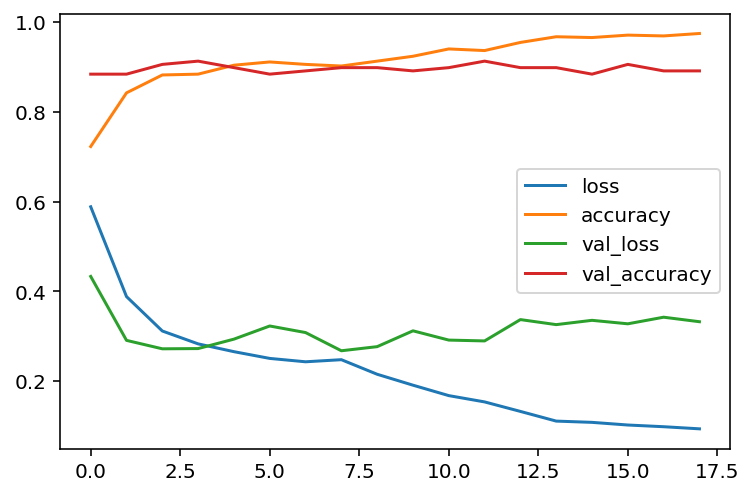

In [16]:
pd.DataFrame(train_1.history).iloc[:, :4].plot();

In [17]:
train_2 = train_model('binary_crossentropy', 'adam', dropout=0.5) # добавим слои для регуляризации

Epoch 1/50
18/18 [==============================] - 0s 7ms/step - loss: 0.6628 - accuracy: 0.5876 - val_loss: 0.5113 - val_accuracy: 0.8406
Epoch 2/50
18/18 [==============================] - 0s 2ms/step - loss: 0.5469 - accuracy: 0.7572 - val_loss: 0.3777 - val_accuracy: 0.8913
Epoch 3/50
18/18 [==============================] - 0s 2ms/step - loss: 0.4446 - accuracy: 0.8276 - val_loss: 0.3215 - val_accuracy: 0.8913
Epoch 4/50
18/18 [==============================] - 0s 2ms/step - loss: 0.3830 - accuracy: 0.8540 - val_loss: 0.2955 - val_accuracy: 0.8841
Epoch 5/50
18/18 [==============================] - 0s 2ms/step - loss: 0.3868 - accuracy: 0.8420 - val_loss: 0.2892 - val_accuracy: 0.8841
Epoch 6/50
18/18 [==============================] - 0s 2ms/step - loss: 0.3726 - accuracy: 0.8577 - val_loss: 0.2781 - val_accuracy: 0.8841
Epoch 7/50
18/18 [==============================] - 0s 2ms/step - loss: 0.3719 - accuracy: 0.8537 - val_loss: 0.2860 - val_accuracy: 0.8913
Epoch 8/50
18/18 [==

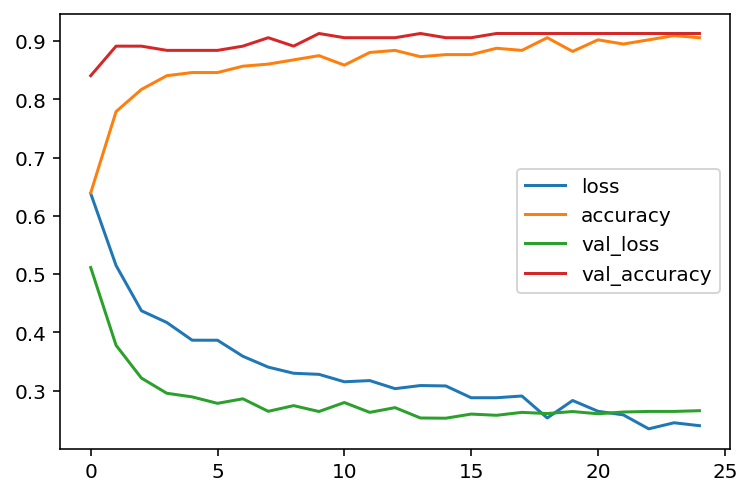

In [18]:
pd.DataFrame(train_2.history).iloc[:, :4].plot();

In [19]:
train_3 = train_model('hinge', 'rmsprop', dropout=0.5) # попробуем другой оптимизатор и функцию потерь

Epoch 1/50
18/18 [==============================] - 1s 8ms/step - loss: 1.0112 - accuracy: 0.6092 - val_loss: 0.9174 - val_accuracy: 0.8261
Epoch 2/50
18/18 [==============================] - 0s 2ms/step - loss: 0.8595 - accuracy: 0.7909 - val_loss: 0.7919 - val_accuracy: 0.8986
Epoch 3/50
18/18 [==============================] - 0s 2ms/step - loss: 0.7596 - accuracy: 0.8337 - val_loss: 0.7553 - val_accuracy: 0.8986
Epoch 4/50
18/18 [==============================] - 0s 2ms/step - loss: 0.7445 - accuracy: 0.8380 - val_loss: 0.7409 - val_accuracy: 0.8986
Epoch 5/50
18/18 [==============================] - 0s 2ms/step - loss: 0.7119 - accuracy: 0.8564 - val_loss: 0.7302 - val_accuracy: 0.9130
Epoch 6/50
18/18 [==============================] - 0s 2ms/step - loss: 0.6732 - accuracy: 0.8606 - val_loss: 0.7300 - val_accuracy: 0.8986
Epoch 7/50
18/18 [==============================] - 0s 2ms/step - loss: 0.7287 - accuracy: 0.8283 - val_loss: 0.7210 - val_accuracy: 0.9058
Epoch 8/50
18/18 [==

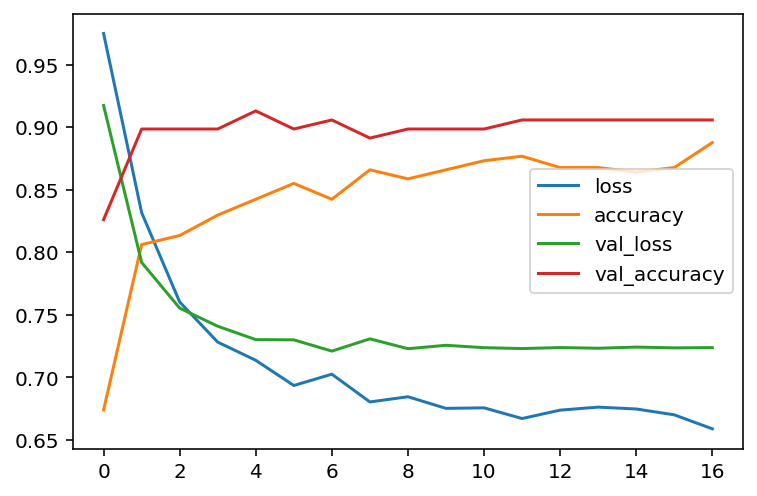

In [20]:
pd.DataFrame(train_3.history).iloc[:, :4].plot();